In [10]:
%matplotlib notebook

In [170]:
# C = np.vstack(cc_dist_do.keys())
# for c in range(24): 
#     ix = np.nonzero(C[:, 0] == c)[0]
#     print('com %d, N = %d'%(c, len(ix)))

<IPython.core.display.Javascript object>


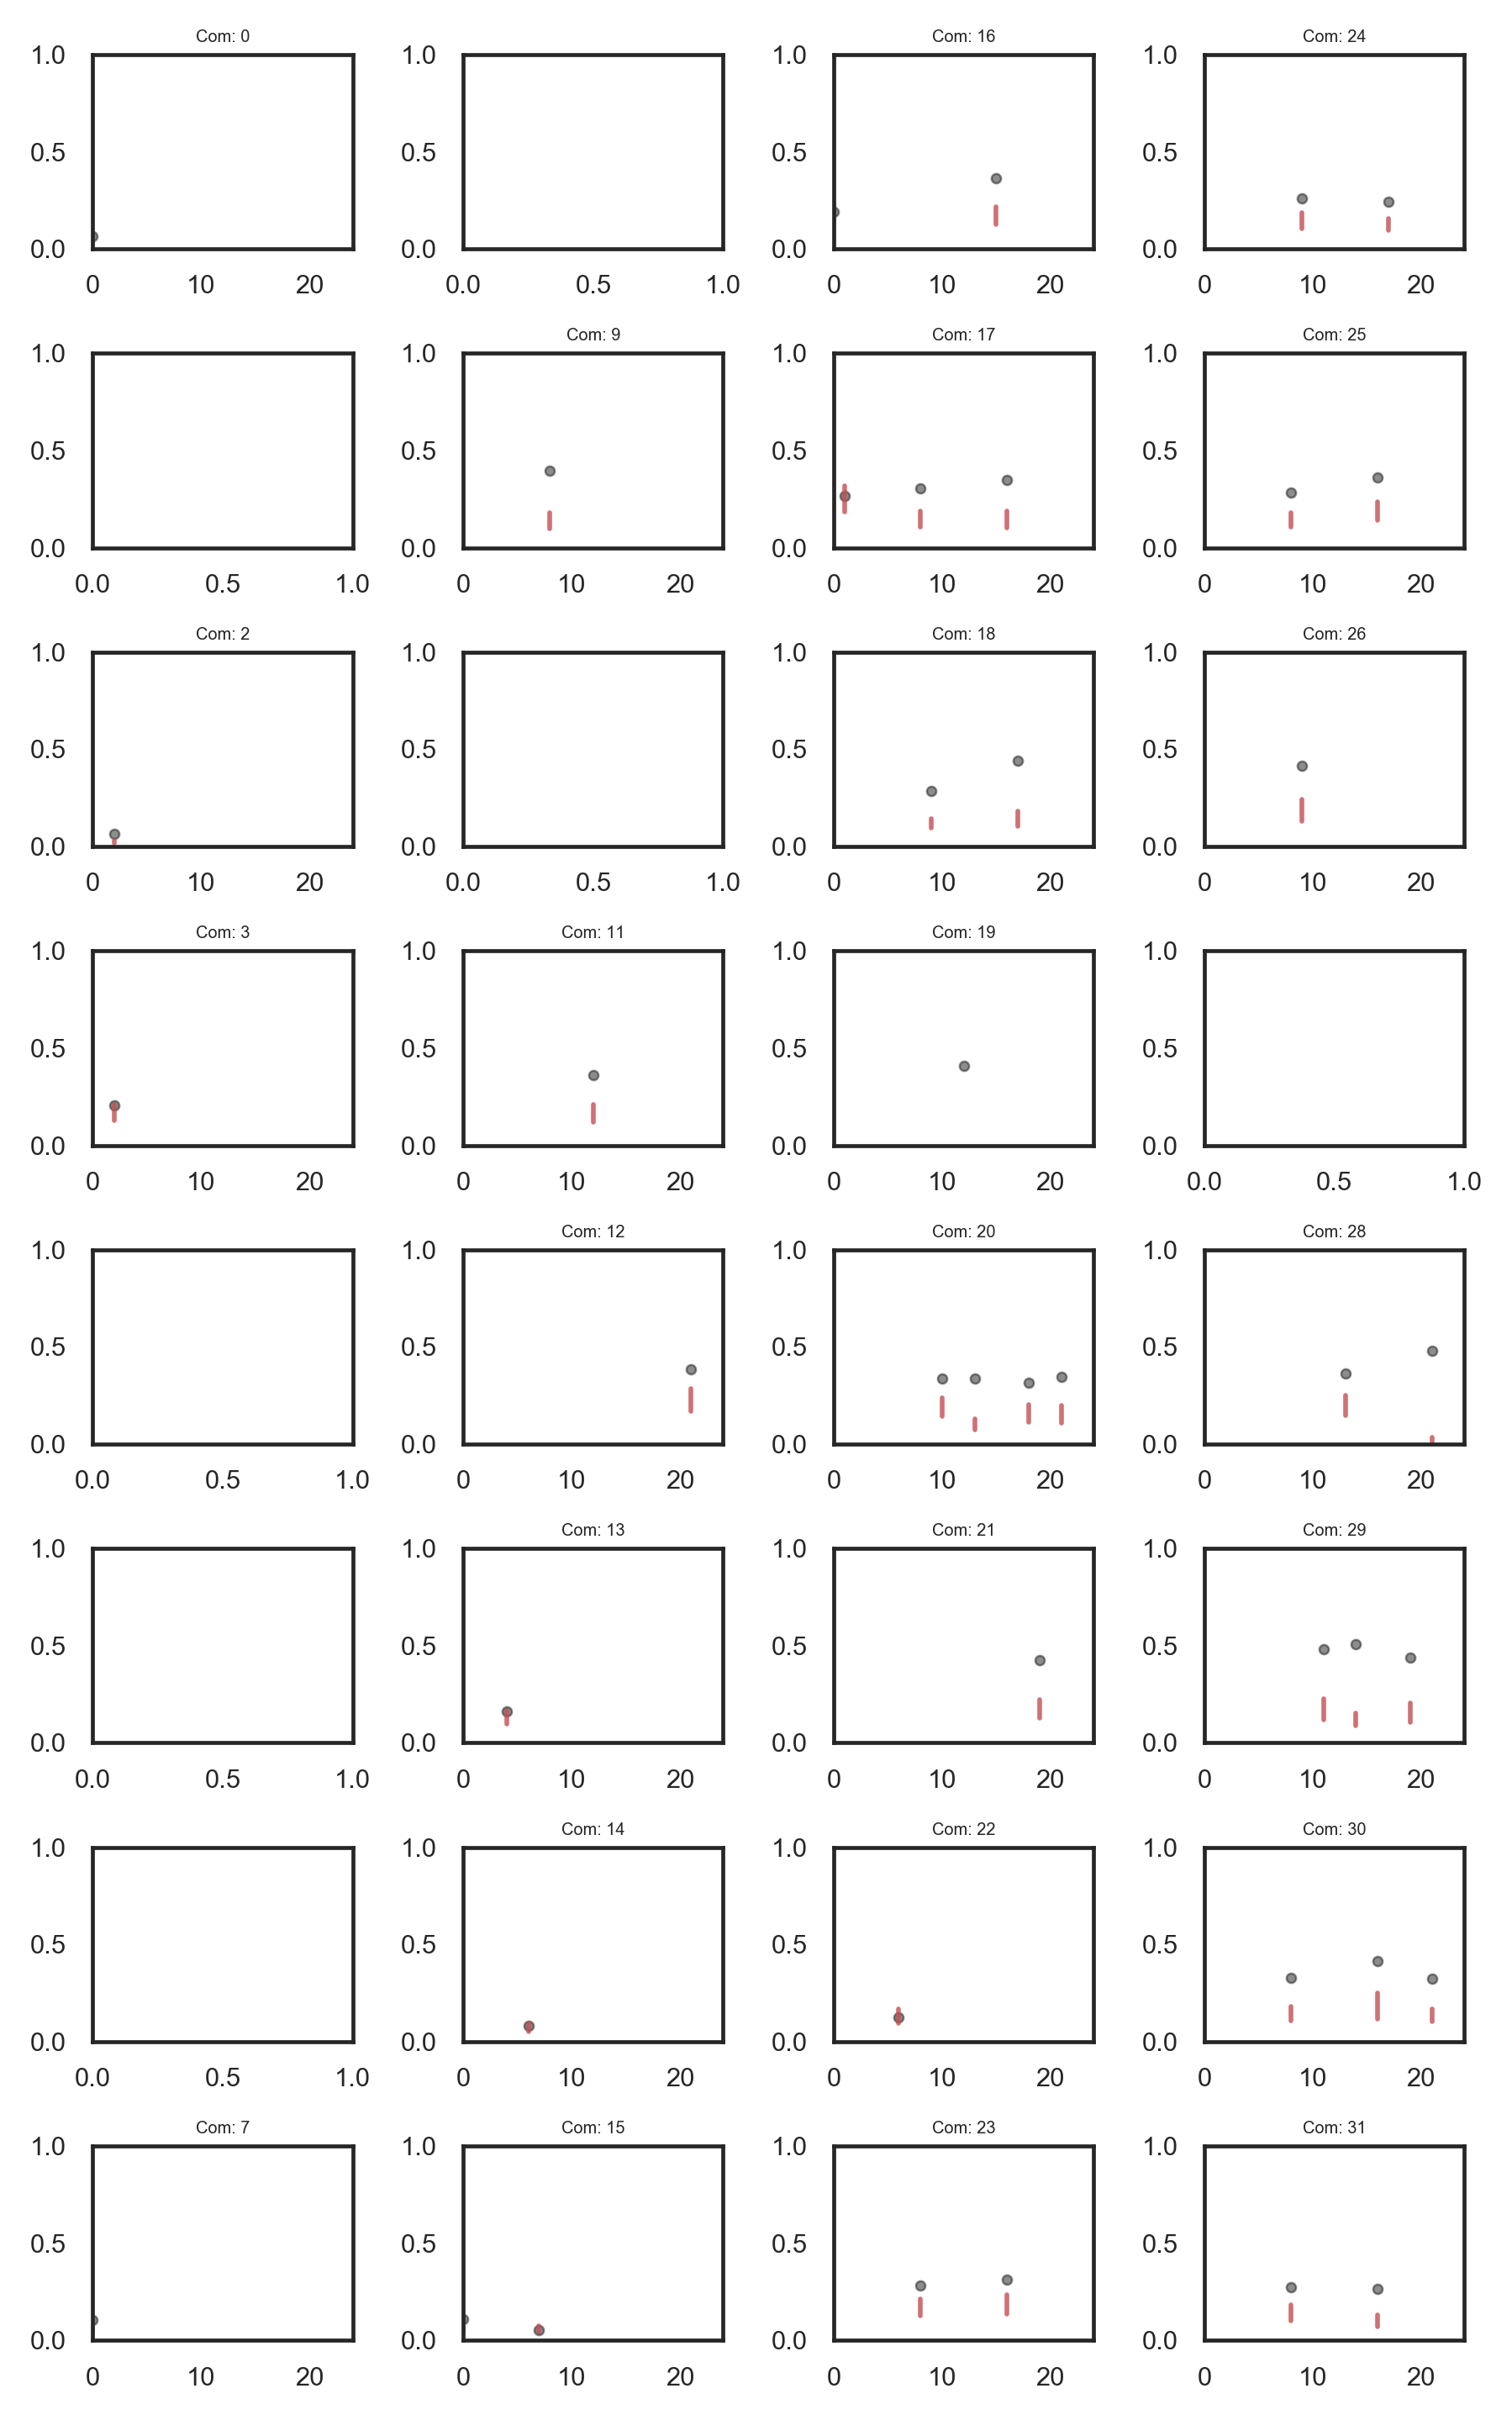

<IPython.core.display.Javascript object>


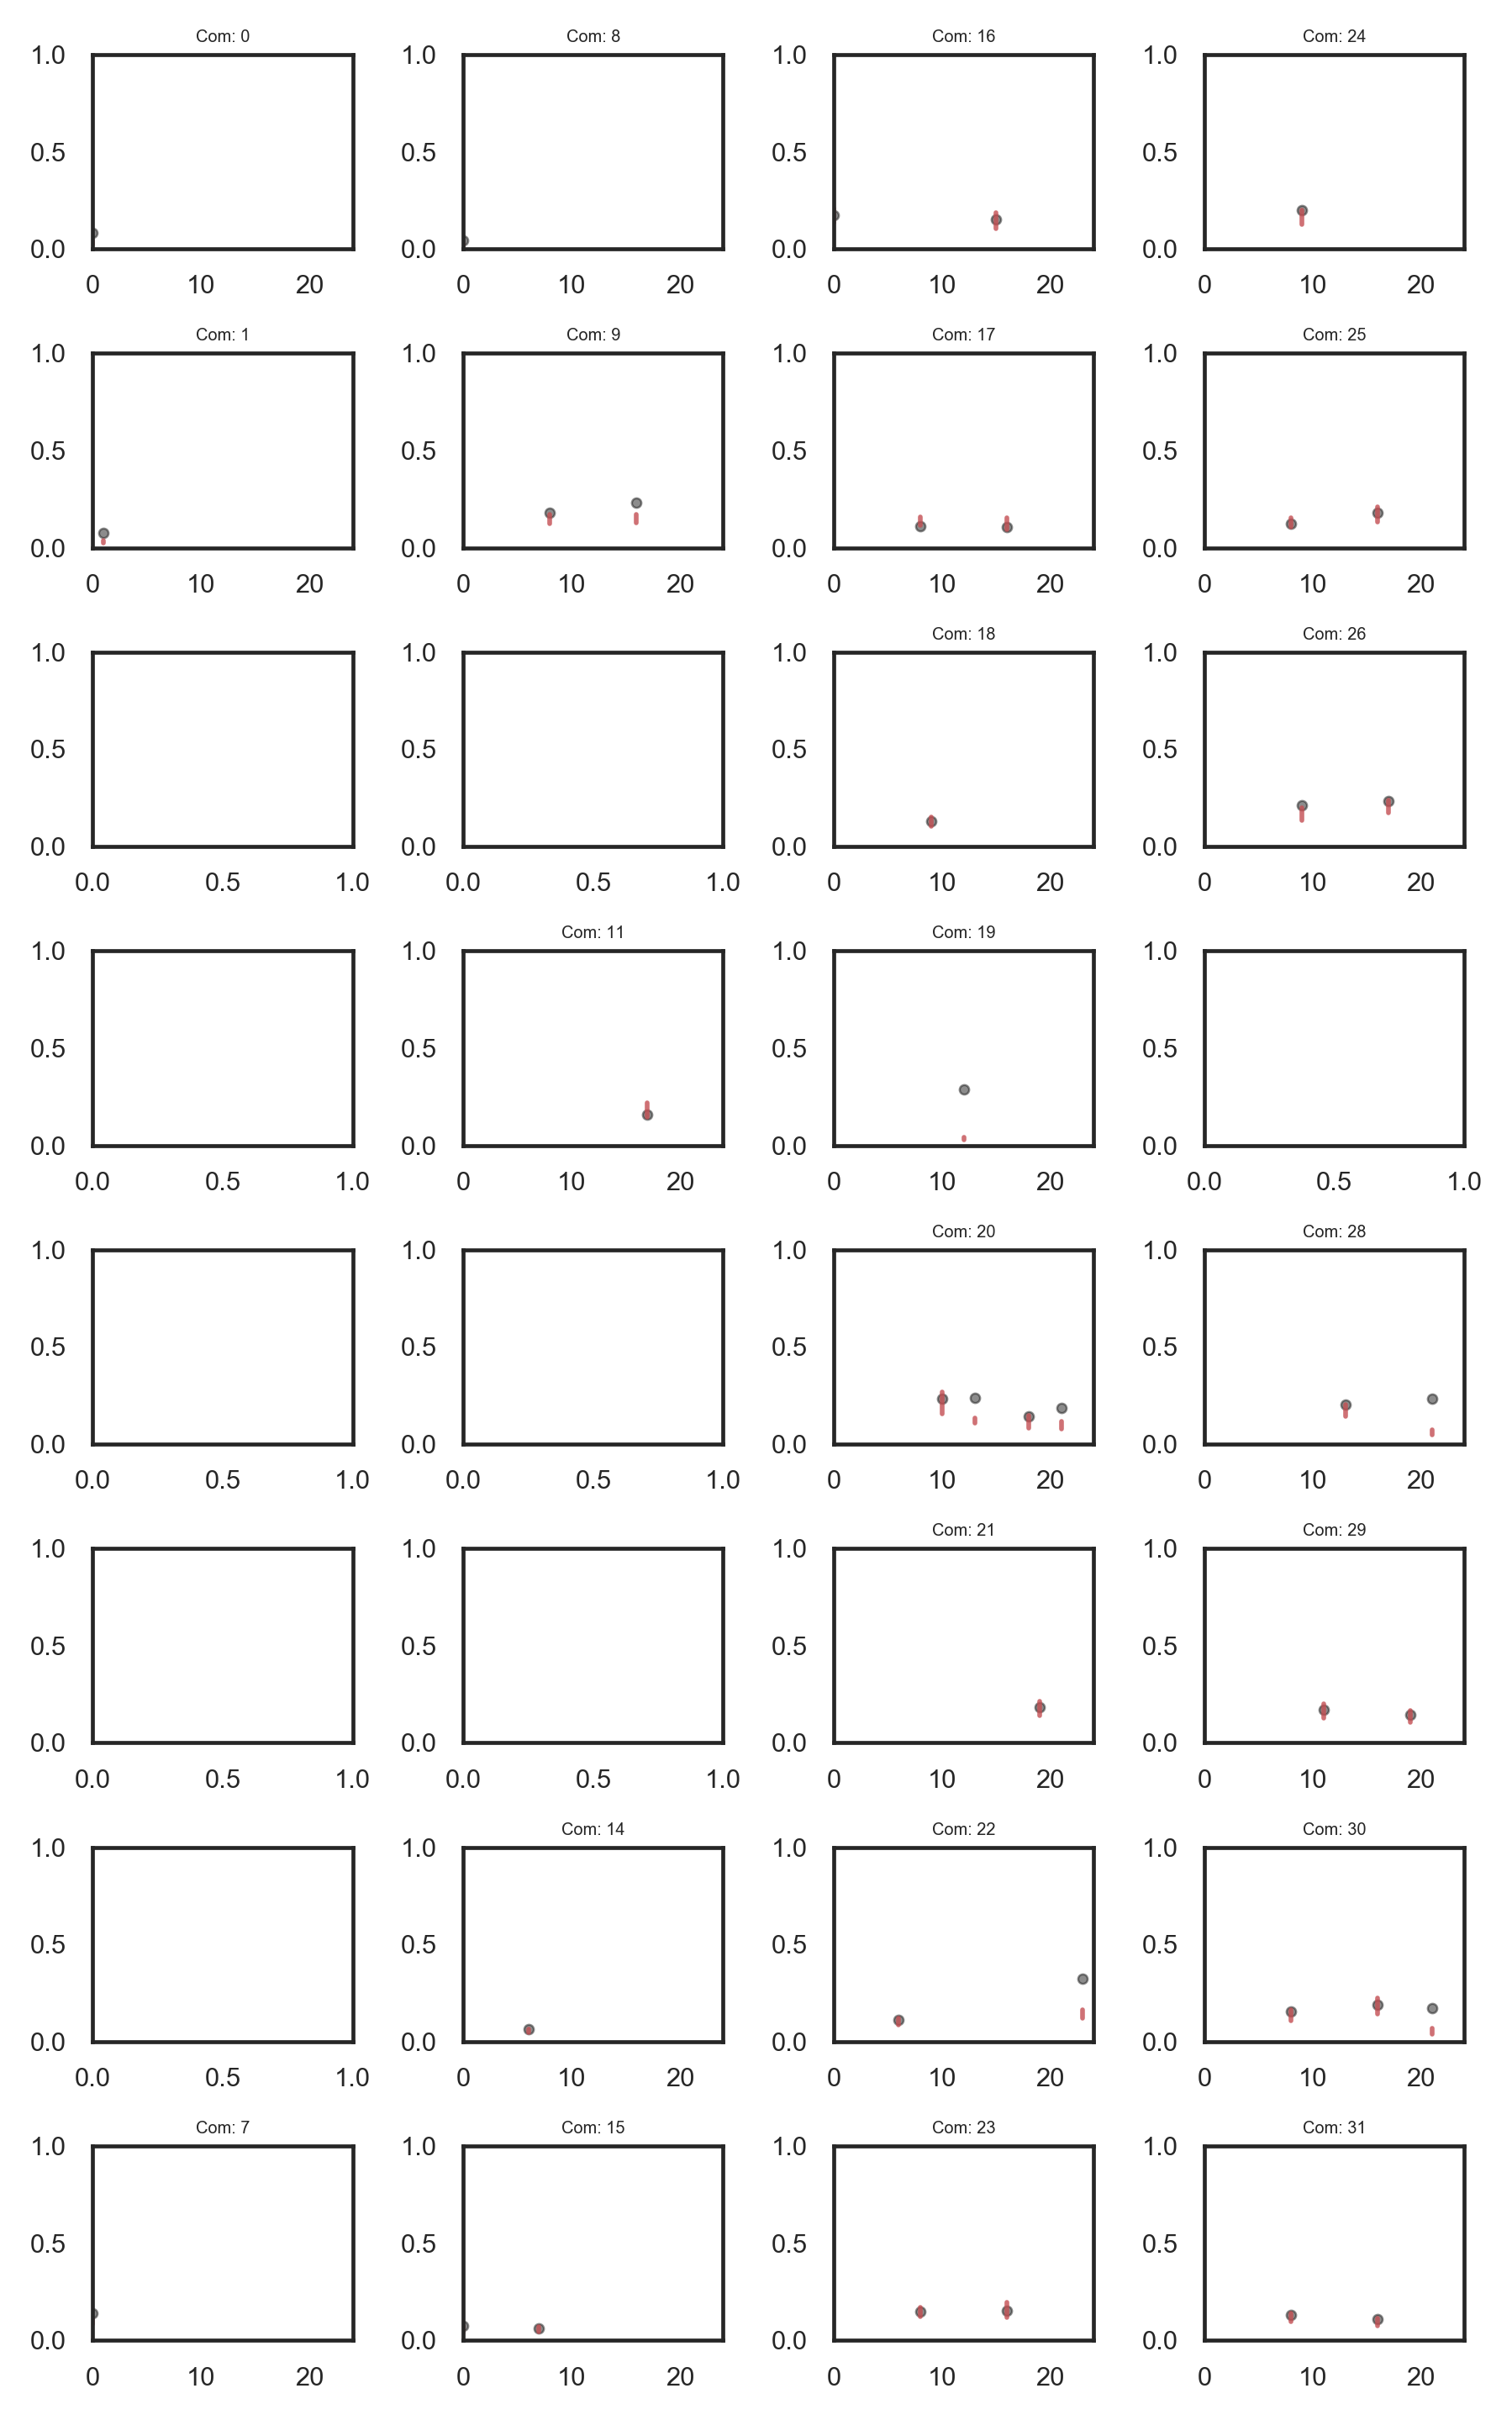

<IPython.core.display.Javascript object>


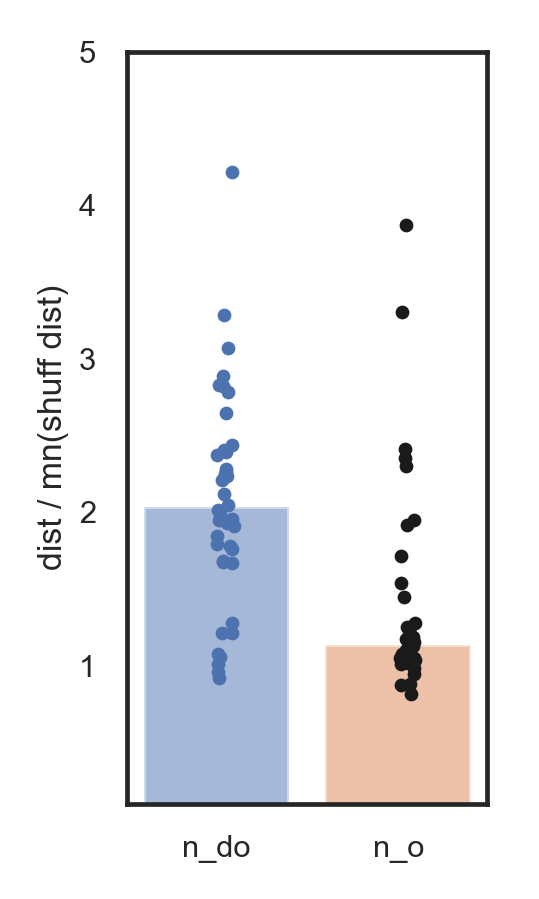

In [72]:
### get out data
act, com, cond, pot = return_data(model = 'n_do')
cc_dist_do, shuff_cc_dist_do = get_cond_com_pls_matched_inds(com, cond, act, pot, nshuff=100)
plot(cc_dist_do, shuff_cc_dist_do, 'null_do')

# ### get out data
act, com, cond, pot = return_data(model = 'n_o')
cc_dist_o, shuff_cc_dist_o = get_cond_com_pls_matched_inds(com, cond, act, pot)
plot(cc_dist_o, shuff_cc_dist_o, 'null_o')
 
f, ax = plt.subplots(figsize = (3, 5))
nm = []
for k in cc_dist_do.keys(): 
    norm = cc_dist_do[k] / np.mean(shuff_cc_dist_do[k])
    ax.plot(.1*np.random.rand(), norm, 'b.')
    nm.append(norm)
ax.bar(0, np.median(nm), alpha=0.5)

nm = []
for k in cc_dist_o.keys(): 
    norm = cc_dist_o[k] / np.mean(shuff_cc_dist_o[k])
    ax.plot(1 + .1*np.random.rand(), norm, 'k.')
    nm.append(norm)
ax.bar(1, np.median(nm), alpha=0.5)
ax.set_ylim([.1, 5.])
ax.set_xticks([0, 1])
ax.set_xticklabels(['n_do', 'n_o'])
ax.set_ylabel('dist / mn(shuff dist)')
f.tight_layout()

{}

In [2]:
def return_data(model = 'n_do'): 
    '''
    options to get out data from vivek's DF
    inputs: 
        model: 'n_do' or 'n_o'
    '''
    df = pickle.load(open('/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/data/lqr_sim_Q2_decoder_null.pkl'))
    N = df['num_neurons']
    cols = ['n_%d'%n for n in range(N)]
    act = np.array(df['df_lqr_n'].loc[:, cols])
    
    ### Get command ID \n",
    mag = np.array(df['df_lqr_n'].loc[:, 'u_v_mag_bin'])
    ang = np.array(df['df_lqr_n'].loc[:, 'u_v_angle_bin'])
    command = mag*8 + ang; 

    ## Get condition 
    target = np.array(df['df_lqr_n'].loc[:, 'target'])
    targ_rot = np.array(df['df_lqr_n'].loc[:, 'task_rot'])
    targ_rot[targ_rot == 1.1] = 1.
    targ_rot[targ_rot == 1.2] = 2.
    condition = targ_rot*8 + target
    assert(len(np.unique(condition)) == 24)
    assert(np.allclose(np.unique(condition), np.arange(24)))

    model_all = np.array(df['df_lqr_n'].loc[:, 'model'])
    ix_ = np.nonzero(model_all == model)[0]

    KG = np.array(df['Kn'])
    KG_vel = KG[[2, 3], :]
    potent = np.dot(KG_vel, act.T).T

    return act[ix_, :], command[ix_], condition[ix_], potent[ix_]

In [12]:
def get_cond_com_pls_matched_inds(commands, condition, activity, potent, nshuff=10, pv=.05): 
    '''
    method that takes in command numbers // condition number // activity 
    '''
    assert(len(commands) == len(condition) == activity.shape[0])
    cc_dist = {}
    shuff_cc_dist = {} 

    for com in np.arange(32): # dont' include commands for 4*8 onwards 
        for cond in np.unique(condition): 

            ## command-condition 
            ix_cc = np.nonzero(np.logical_and(commands == com, condition == cond))[0]
            #print('Command %d, Cond %d, N=%d'%(com, cond, len(ix_cc)))
            if len(ix_cc) > 0: 
                
                ## Find condition pool that matches this 
                ix_com = np.nonzero(commands == com)[0]

                ## Return indices that match 
                #print('Starting match cond: %d, com %d'%(cond, com))
                if np.all(potent[ix_cc].reshape(-1) == 0) and np.all(potent[ix_com].reshape(-1) == 0):
                    pass
                else:
                    ix_com = match_ix(ix_cc, ix_com, potent, pv=pv)
                    
                if ix_com is not None: 
                    #print('Command %d Cond %d, ix_cc N=%d, ix_com N=%d'%(com, cond, len(ix_cc), len(ix_com)))

                    shuff_cc_dist[com, cond] = []

                    # Global pool
                    pool_mn = np.mean(activity[ix_com, :], axis=0)

                    # Shuffle_dist
                    for i_shuff in range(nshuff): 

                       ## which indices 
                        ix_ = np.random.permutation(len(ix_com))[:len(ix_cc)]
                        mn_ = np.mean(activity[ix_com[ix_], :], axis=0)
                        shuff_cc_dist[com,cond].append(np.linalg.norm(pool_mn - mn_))

                    cc_dist[com, cond] = np.linalg.norm(pool_mn - np.mean(activity[ix_cc, :], axis=0))
    return cc_dist, shuff_cc_dist

In [13]:
def match_ix(ix0, ix1, val, pv=.5): 
    '''
    method to do matching
    '''
    assert(val.shape[1] == 2) # 2D command 

    ix1_keep = np.arange(len(ix1))
    _, px = scipy.stats.ttest_ind(val[ix0, 0], val[ix1[ix1_keep], 0])
    _, py = scipy.stats.ttest_ind(val[ix0, 1], val[ix1[ix1_keep], 1])

    mn0 = np.mean(val[ix0, :], axis=0)
    st0 = np.std(val[ix0, :], axis=0)

    while np.logical_or(px < pv, py < pv): 

        cost = np.sum(np.square((val[ix1[ix1_keep]] - mn0[np.newaxis, :])/st0[np.newaxis, :]), axis=1)
        assert(len(cost) == len(ix1_keep))

        # Drop last 5%: 
        N = len(ix1_keep)
        keep_N = int(np.round(.9*N))
        ix1_keep = np.argsort(cost)[:keep_N]
        ix1_keep = np.sort(ix1_keep)
        #print('Len ix1 %d'%len(ix1_keep))

        _, px = scipy.stats.ttest_ind(val[ix0, 0], val[ix1[ix1_keep], 0])
        _, py = scipy.stats.ttest_ind(val[ix0, 1], val[ix1[ix1_keep], 1])
        
        if len(ix1_keep) <= len(ix0): 
            break

    if np.logical_and(px >= pv, py >= pv):
        #print('Success ix1 %d'%len(ix1_keep))
        return ix1[ix1_keep]

    else:
        #print('Failure')
        return None

In [33]:
def plot(cc_dist, shuff_cc_dist, title):
    f, ax = plt.subplots(nrows = 8, ncols = 4, figsize = (10, 16))
    for i_k, k in enumerate(cc_dist.keys()):
        
        com, cond = k; 
        axi = ax[ com % 8, int(np.floor(com/8))]
        
        axi.plot(cond, cc_dist[k], 'k.', alpha=.5)
        
        mn_shuff = np.mean(shuff_cc_dist[k])
        st_shuff = np.std(shuff_cc_dist[k])
        axi.plot([cond, cond], [mn_shuff - 2*st_shuff, mn_shuff+2*st_shuff], 'r-', alpha=.8)
        axi.set_title('Com: %d'%com, fontsize=8)
        axi.set_xlim([0., 24.])
        axi.set_ylim([0., 1.0])
    #ax.set_title(title)
    f.tight_layout()

In [34]:
########## simulations to check if shuffle z-score is fcn of size of pool? 

In [2]:
def generate_data(ncond = 2, ncom_conds=100, addl_pool = 0, Nneur=44, nstd = 1):
    
    ## generate data: 
    #X = nstd*np.random.randn(ncond*ncom_conds + addl_pool, Nneur)
    X = nstd*np.random.randn(ncond*ncom_conds + addl_pool, Nneur)
    
    ## condition labels 
    Cond = np.zeros((ncond*ncom_conds + addl_pool))
    
    for i in range(ncond): 
        Cond[i*ncom_conds:((i+1)*ncom_conds)] = (i+1)
        
    Pot = np.zeros((Cond.shape[0], 2))
    Comm = np.zeros((Cond.shape[0], ))
    return Comm, Cond, X, Pot

In [3]:
def plot2(cc_dist, shuff_cc_dist, title):
    f, ax = plt.subplots()
    for i_k, k in enumerate(cc_dist.keys()):
        
        com, cond = k; 
        axi = ax; 
        axi.plot(cond, cc_dist[k], 'k.', alpha=.5)
        
        mn_shuff = np.mean(shuff_cc_dist[k])
        st_shuff = np.std(shuff_cc_dist[k])
        axi.plot([cond, cond], [mn_shuff - 2*st_shuff, mn_shuff+2*st_shuff], 'r-', alpha=.8)
        axi.set_title('Com: %d'%com, fontsize=8)
        axi.set_xlim([-1, 11])
    #ax.set_title(title)
    f.tight_layout()

In [4]:
def get_z(cc_dist, shuff_cc_dist): 
    Z = []; 
    for i_k, k in enumerate(cc_dist.keys()): 
        com, cond = k 
        if cond > 0: 
            mn_shuff = np.mean(shuff_cc_dist[k])
            st_shuff = np.std(shuff_cc_dist[k])
            z_ = (cc_dist[k] - mn_shuff) / st_shuff
            Z.append(z_)
    return Z

In [51]:
pool_factor

11.0

In [33]:
save = dict(zsc=[], cc_dist =[], shuff_mn=[], shuff_std=[]); 
xl = []; n_conds = 2; npts = 10; std = 2; N = 10; 

### Sweep pool factor: 
for pv in [.1, .2, .3, .4, .5, .6, .7, .8, .9]: 
    
    ### Pool factor
    #pool_factor = ((n_conds*npts)+N)/float(npts)
    
    ### Gather data 
    Zall = []; CC_dist = []; Sall = []; SSall = []; 
    
    for i in range(50): 
        
        ### Get data 
        Comm, Cond, X, Pot = generate_data(addl_pool=N, ncond=n_conds, ncom_conds=npts, nstd = std)
        
        ### Get command-conditions 
        cc_dist, shuff_cc_dist = get_cond_com_pls_matched_inds(Comm, Cond, X, Pot, nshuff=50, pv=pv)
        
        ### Get Z 
        Z = get_z(cc_dist, shuff_cc_dist)
        Zall.append(Z)
        
        cnt = 0; 
        for k in shuff_cc_dist.keys(): 
            com, cond = k
            
            ### Only take conditions > 
            if cond > 0: 
                Sall.append(np.mean(shuff_cc_dist[k]))
                SSall.append(np.std(shuff_cc_dist[k]))
                CC_dist.append(cc_dist[k])
                
                cnt += 1
        assert(cnt == n_conds)
    
    save['cc_dist'].append(np.hstack((CC_dist)))
    save['zsc'].append(np.hstack((Zall)))
    save['shuff_mn'].append(np.hstack((Sall)))
    save['shuff_std'].append(np.hstack((SSall)))
    
    xl.append(pv)


In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


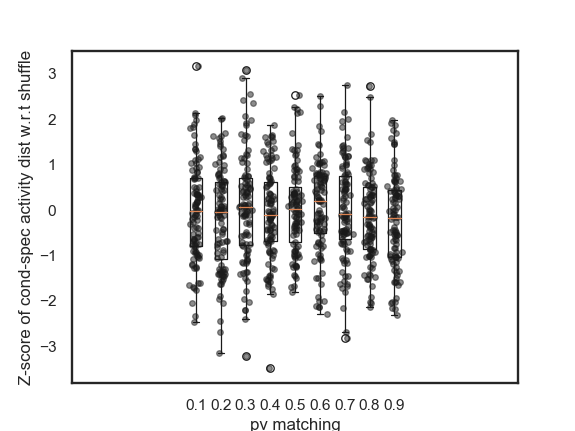

Text(0,0.5,'Z-score of cond-spec activity dist w.r.t shuffle')

In [36]:
f, ax = plt.subplots()
xl2 = np.array(xl)
ax.boxplot(save['zsc'], positions=xl2, widths=.05)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['zsc'])): 
    n = len(save['zsc'][i])
    ax.plot(np.zeros((n,)) + xl2[i] + .01*np.random.randn(n, ), save['zsc'][i], 'k.', alpha=.5)
ax.set_xlabel('pv matching')
ax.set_ylabel('Z-score of cond-spec activity dist w.r.t shuffle')

# ax2 = ax.twinx()
# ax2.boxplot(save['cc_dist'], positions=xl)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
# for i in range(len(save['cc_dist'])): 
#     n = len(save['cc_dist'][i])
#     ax2.plot(np.zeros((n,)) + xl[i] + .1*np.random.randn(n, ), save['cc_dist'][i], 'b.', alpha=.5)
# ax2.set_ylabel('CC_dist activity dist w.r.t shuffle')

<IPython.core.display.Javascript object>


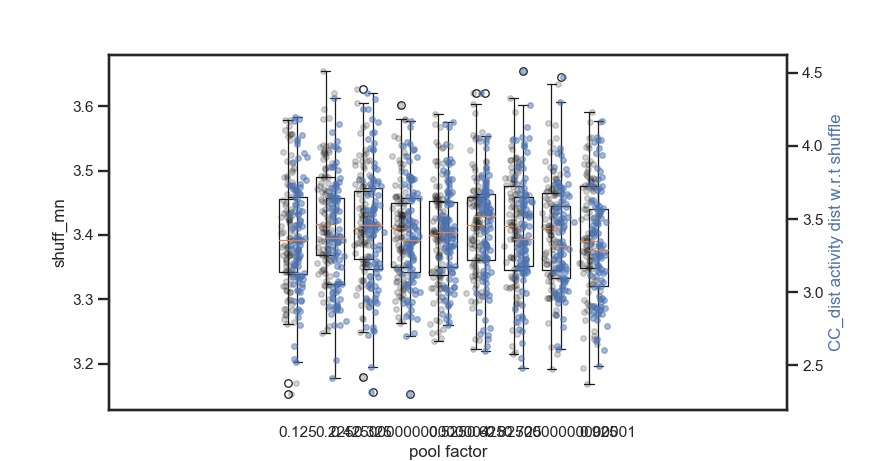

Text(0,0.5,'CC_dist activity dist w.r.t shuffle')

In [38]:
f, ax = plt.subplots()

plt.boxplot(save['shuff_mn'], positions=xl2, widths=.05)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['shuff_mn'])): 
    n = len(save['shuff_mn'][i])
    plt.plot(np.zeros((n,)) + xl2[i] + .01*np.random.randn(n, ), save['shuff_mn'][i], 'k.', alpha=.2)
plt.xlabel('pool factor')
plt.ylabel('shuff_mn')

ax2 = ax.twinx()
ax2.boxplot(save['cc_dist'], positions=np.array(xl2)+.025, widths=.05)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['cc_dist'])): 
    n = len(save['cc_dist'][i])
    ax2.plot(np.zeros((n,)) + xl2[i] + .01*np.random.randn(n, )+.025, save['cc_dist'][i], 'b.', alpha=.5)
ax2.set_ylabel('CC_dist activity dist w.r.t shuffle', color='b')

#ax.set_ylim([.6, 1.2])
#x2.set_ylim([.6, 1.2])

<IPython.core.display.Javascript object>


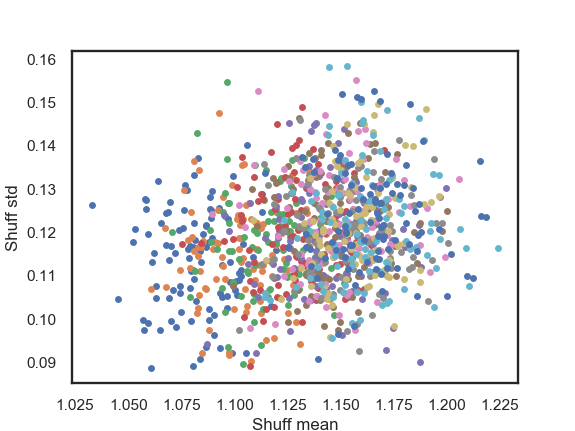

Text(0,0.5,'Shuff std')

In [18]:
f, ax = plt.subplots()
std = save['shuff_std']
mn = save['shuff_mn']
#colors = ['maroon','orangered','goldenrod','olivedrab','teal','steelblue','navy','mediumpurple','purple','magenta','brown']
for i in range(len(colors)): 
    ax.plot(mn[i], std[i], '.')#, color=colors[i])
ax.set_xlabel('Shuff mean')
ax.set_ylabel('Shuff std')

In [72]:
### just increase N
save = dict(zsc=[], shuff_mn=[], shuff_std=[], cc_dist =[]); 
xl = []; 
n_conds = 2; 

for npts in np.arange(50, 500, 50): 
    Zall = []; Sall = []; SSall = []; CC_dist = []; 
    for i in range(100): 
        Comm, Cond, X, Pot = generate_data(addl_pool=0, ncond=n_conds, ncom_conds=npts)
        cc_dist, shuff_cc_dist = get_cond_com_pls_matched_inds(Comm, Cond, X, Pot, nshuff=50)
        Z = get_z(cc_dist, shuff_cc_dist)
        Zall.append(Z)
        
        cnt = 0 
        for k in shuff_cc_dist.keys(): 
            com, cond = k 
            if cond > 0: 
                Sall.append(np.mean(shuff_cc_dist[k]))
                SSall.append(np.std(shuff_cc_dist[k]))
                CC_dist.append(cc_dist[k])
                cnt += 1
        assert(cnt == n_conds)
    
    save['zsc'].append(np.hstack((Zall)))
    save['shuff_mn'].append(np.hstack((Sall)))
    save['shuff_std'].append(np.hstack((SSall)))
    save['cc_dist'].append(np.hstack((CC_dist)))
    
    xl.append(npts)


<IPython.core.display.Javascript object>


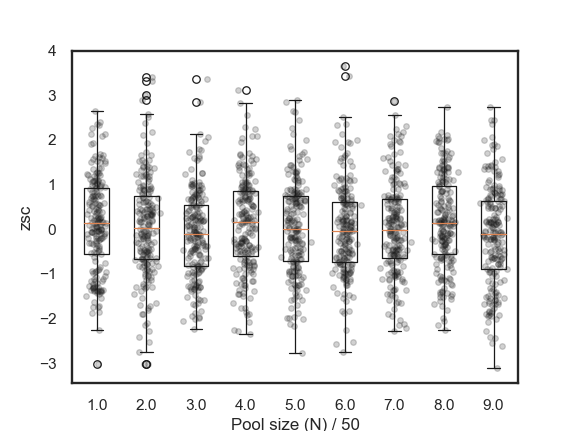

Text(0.5,0,'Pool size (N) / 50')

In [73]:
f, ax = plt.subplots()
xl2 = np.array(xl)/50.
plt.boxplot(save['zsc'], positions=xl2)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['zsc'])): 
    n = len(save['zsc'][i])
    plt.plot(np.zeros((n,)) + xl2[i] + .1*np.random.randn(n, ), save['zsc'][i], 'k.', alpha=.2)
plt.ylabel('zsc')
plt.xlabel('Pool size (N) / 50')

<IPython.core.display.Javascript object>


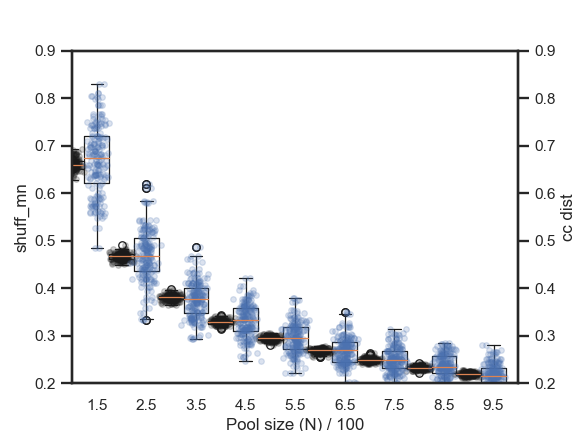

(0.2, 0.9)

In [78]:
f, ax = plt.subplots()
xl2 = np.array(xl)/50.
ax.boxplot(save['shuff_mn'], positions=xl2)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['shuff_mn'])): 
    n = len(save['shuff_mn'][i])
    ax.plot(np.zeros((n,)) + xl2[i] + .1*np.random.randn(n, ), save['shuff_mn'][i], 'k.', alpha=.2)
ax.set_ylabel('shuff_mn')
ax.set_xlabel('Pool size (N) / 100')

ax2 = ax.twinx()
ax2.boxplot(save['cc_dist'], positions=xl2+.5)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['cc_dist'])): 
    n = len(save['cc_dist'][i])
    ax2.plot(np.zeros((n,)) + xl2[i] + .1*np.random.randn(n, )+.5, save['cc_dist'][i], 'b.', alpha=.2)
ax2.set_ylabel('cc dist')
ax.set_ylim([.2, .9])
ax2.set_ylim([.2, .9])


<IPython.core.display.Javascript object>


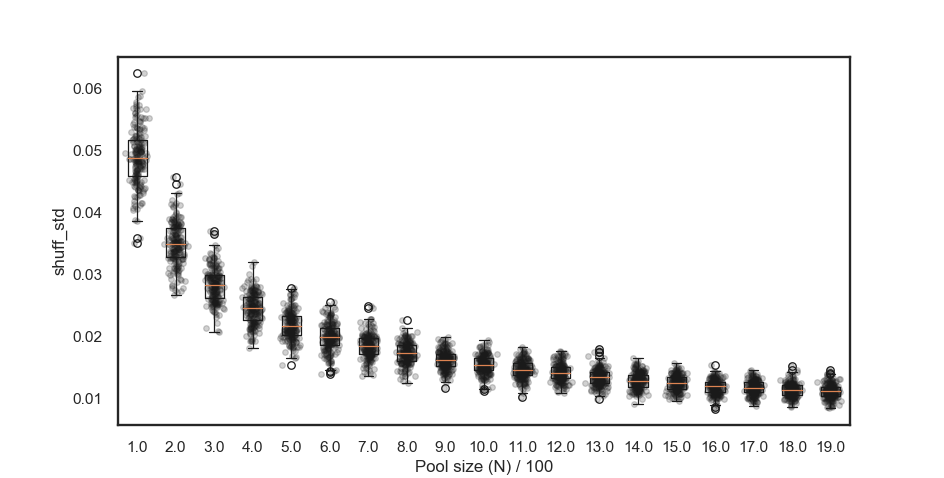

Text(0.5,0,'Pool size (N) / 100')

In [167]:
f, ax = plt.subplots()
plt.boxplot(save['shuff_std'], positions=xl2)#, flierprops={'marker': '+', 'markersize': 10, 'markerfacecolor': 'red'})
for i in range(len(save['shuff_std'])): 
    n = len(save['shuff_std'][i])
    plt.plot(np.zeros((n,)) + xl2[i] + .1*np.random.randn(n, ), save['shuff_std'][i], 'k.', alpha=.2)
plt.ylabel('shuff_std')
plt.xlabel('Pool size (N) / 100')
